In [1]:
import pydot
import numpy as np
from queue import Queue
from time import time

In [31]:
class State():
    goal_state = [0,0,0] #missionary, cannibal, river_side
    num_of_instances = 0
    global colours
    colours = ['red', 'gold','green']
    def __init__(self, state,parent,action,depth):
        self.parent = parent
        self.state = state
        self.action = action
        self.depth = depth
        if self.is_killed():
            color=colours[0]
        elif self.is_goal():
            color = colours[1]
        else:
            color=colours[2]
        self.graph_node = pydot.Node(str(self), style='filled', fillcolor=color)
        State.num_of_instances +=1
        
    
    def __str__(self):
        return str(self.state)
    
    
    def is_goal(self):
        if self.state == self.goal_state:
            return True
        return False
    
    
    def is_valid(self):
        if self.state[0] <0 or self.state[0] > 3:
            return False
        if self.state[1] < 0 or self.state[1] > 3:
            return False
        if self.state[2] > 1 or self.state[2] < 0:
            return False
        return True
    
    
    def is_killed(self):
        missionaries = self.state[0]
        cannibals = self.state[1]
        if missionaries < cannibals and missionaries > 0:
            return True
        if missionaries > cannibals and missionaries < 3:
            return True
        
        
    def generate_child(self):
        children = []
        depth = self.depth + 1
        operation = -1
        boat_move = 'moving boat from left shore to right'
        if self.state[2] == 0:
            operation = 1
            boat_move = 'movin boat from right shore to left'
            
        for x in range(3):
            for y in range(3):
                new_state = self.state.copy()
                new_state[0], new_state[1],  new_state[2] = new_state[0] + operation * x, new_state[1] + operation * y, new_state[2] + operation * 1
                action = [x,y,operation]
                new_node = State(new_state,self,action,depth)
                if x + y >=1 and x  + y <=2:
                    children.append(new_node)
        return children
                
    
    def find_solution(self):
        solution = []
        solution.append(self.action)
        path = self
        while path.parent != None:
            path = path.parent
            solution.append(path.action)
        solution = solution[:-1]
        solution.reverse()
        return solution
    

In [45]:
def breadth_first_search_tree(initial_state):
    graph = pydot.Dot(graph_type='digraph',label="Missionaries and Cannibals State Space",fontsize="30", color="red",
                                                    fontcolor="blue",  style="filled", fillcolor="black")
    start_node = State(initial_state, None, None,0)
    if start_node.is_goal():
        return start_node.find_solution()
    q = Queue()
    q.put(start_node)
    explored=[]
    killed=[]
    print("The starting node is \ndepth=%d" % start_node.depth)
    print(str(start_node.state))
    while not(q.empty()):
        node=q.get()
        print("\nthe node selected to expand is\ndepth="+str(node.depth)+"\n"+str(node.state)+"\n")
        explored.append(node.state)
        graph.add_node(node.graph_node)
        if node.parent:
            diff=np.subtract(node.parent.state,node.state)
            if node.parent.state[2]==0:
                diff[0],diff[1]=-diff[0],-diff[1]
            graph.add_edge(pydot.Edge(node.parent.graph_node, node.graph_node,label=str(diff)))
        children=node.generate_child()
        if not node.is_killed():
            print("the children nodes of this node are",end="")
            for child in children:
                if child.state not in explored:
                    print("\ndepth=%d" % child.depth)
                    print(str(child.state))
                    if child.is_goal():
                        print("which is the goal state\n")
                        graph.add_node(child.graph_node)
                        diff = np.subtract(node.parent.state, node.state)
                        if node.parent.state[2] == 0:
                            diff[0], diff[1] = -diff[0], -diff[1]

                        graph.add_edge(pydot.Edge(child.parent.graph_node, child.graph_node,label=str(diff)))

                        # colour all leaves blue
                        leafs = {n.get_name(): True for n in graph.get_nodes()}
                        for e in graph.get_edge_list():
                            leafs[e.get_source()] = False
                        for leaf in leafs:
                            if leafs[leaf] and str(leaf) not in killed and str(leaf)!="\"[0, 0, 0]\"":
                                node = pydot.Node(leaf, style="filled", fillcolor="blue")
                                graph.add_node(node)

                        draw_legend(graph)
                        graph.write_png('state_space_tree.png')

                        return child.find_solution()
                    if child.is_valid():
                        q.put(child)
                        explored.append(child.state)

        else:
            print("This node is killed")
            killed.append("\""+str(node.state)+"\"")

    return


In [46]:
def draw_legend(graph):
    graphlegend = pydot.Cluster(graph_name="legend", label="Legend", fontsize="20", color="red",
                                fontcolor="blue", style="filled", fillcolor="white")

    legend1 = pydot.Node('Processed node', shape="plaintext")
    graphlegend.add_node(legend1)
    legend2 = pydot.Node("Killed Node", shape="plaintext")
    graphlegend.add_node(legend2)
    legend3 = pydot.Node('No new child possible', shape="plaintext")
    graphlegend.add_node(legend3)
    legend4 = pydot.Node('Goal Node', shape="plaintext")
    graphlegend.add_node(legend4)
    legend5=pydot.Node('Node [x,y,z]=> x,y = No. of missionaries and cannibals at left shore\n'
                       '               If z=1 -> boat at left shore\n'
                       '               If z=0-> boat at right shore\n'
                       'Edge [x,y,z]=> If z=1-> Move x missionaries and y cannibals to right shore\n'
                       '               If z=-1-> Move x missionaries and y cannibals to left shore', shape="plaintext",fontsize="15")
    graphlegend.add_node(legend5)

    node1 = pydot.Node("1", style="filled", fillcolor="green", label="")
    graphlegend.add_node(node1)
    node2 = pydot.Node("2", style="filled", fillcolor="red", label="")
    graphlegend.add_node(node2)
    node3 = pydot.Node("3", style="filled", fillcolor="blue", label="")
    graphlegend.add_node(node3)
    node4 = pydot.Node("4", style="filled", fillcolor="gold", label="")
    graphlegend.add_node(node4)

    graph.add_subgraph(graphlegend)
    graph.add_edge(pydot.Edge(legend1, legend2, style="invis"))
    graph.add_edge(pydot.Edge(legend2, legend3, style="invis"))
    graph.add_edge(pydot.Edge(legend3, legend4, style="invis"))
    graph.add_edge(pydot.Edge(legend4, legend5, style="invis"))
    graph.add_edge(pydot.Edge(node1, node2, style="invis"))
    graph.add_edge(pydot.Edge(node2, node3, style="invis"))
    graph.add_edge(pydot.Edge(node3, node4, style="invis"))

In [47]:
initial_state = [3,3,1]

In [48]:
State.num_of_instances = 0

In [49]:
solution = breadth_first_search_tree(initial_state)
print(f"Solution: {solution}")

The starting node is 
depth=0
[3, 3, 1]

the node selected to expand is
depth=0
[3, 3, 1]

the children nodes of this node are
depth=1
[3, 2, 0]

depth=1
[3, 1, 0]

depth=1
[2, 3, 0]

depth=1
[2, 2, 0]

depth=1
[1, 3, 0]

the node selected to expand is
depth=1
[3, 2, 0]

the children nodes of this node are
depth=2
[3, 4, 1]

depth=2
[4, 2, 1]

depth=2
[4, 3, 1]

depth=2
[5, 2, 1]

the node selected to expand is
depth=1
[3, 1, 0]

the children nodes of this node are
depth=2
[3, 2, 1]

depth=2
[4, 1, 1]

depth=2
[4, 2, 1]

depth=2
[5, 1, 1]

the node selected to expand is
depth=1
[2, 3, 0]

This node is killed

the node selected to expand is
depth=1
[2, 2, 0]

the children nodes of this node are
depth=2
[2, 3, 1]

depth=2
[2, 4, 1]

depth=2
[4, 2, 1]

the node selected to expand is
depth=1
[1, 3, 0]

This node is killed

the node selected to expand is
depth=2
[3, 2, 1]

the children nodes of this node are
depth=3
[3, 0, 0]

depth=3
[2, 1, 0]

depth=3
[1, 2, 0]

the node selected to expan

In [50]:
from IPython import display

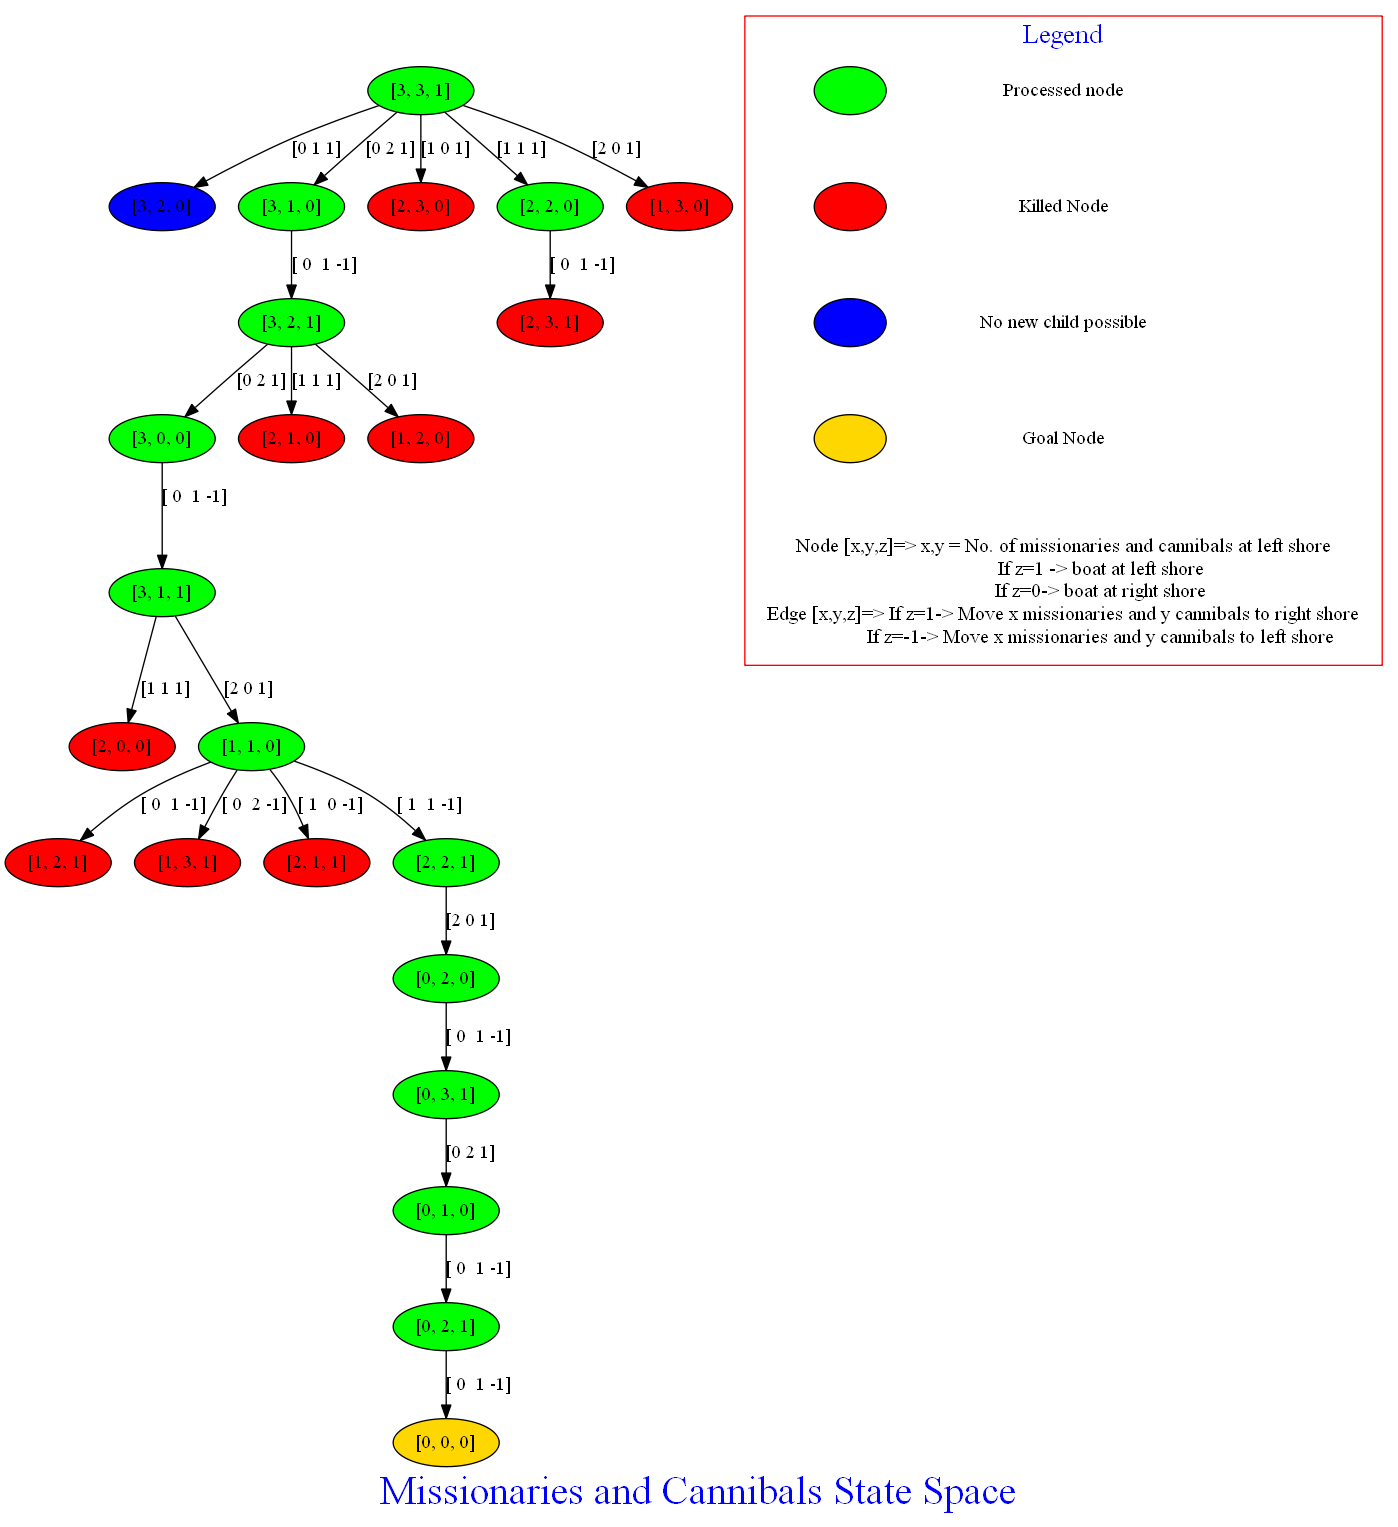

In [51]:
display.Image('state_space_tree.png')